# Training Notebook

Train Cascade Mask-RCNN

Add a couple additional things: 
- Validation Loop using loss 
- Checkpoint based off of best validation metrics
- Custom COCO Style Dataloaders

In [1]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger

setup_logger()

# python libraries
import numpy as np
import os, json, random, math, time, datetime, logging
import torch, cv2
import matplotlib.pyplot as plt

%matplotlib inline

# d2 libraries
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.config import get_cfg
from detectron2.utils import comm
from detectron2.utils.logger import log_every_n_seconds
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.engine.hooks import EvalHook, BestCheckpointer
from detectron2.data import (
    MetadataCatalog,
    DatasetCatalog,
    build_detection_train_loader,
    build_detection_test_loader,
    get_detection_dataset_dicts,
    DatasetMapper,
)
import detectron2.data.transforms as T

# my stuff
from data_utils import read_split_file, random_split_mixed_set, register_dataset, generate_missed_detections_data
import elevator_datasets

### Randomly Split Data

Generate Recovery Model Training Data if necessary \
Generate split following segmentation model

In [2]:
if not os.path.exists(elevator_datasets.MIXED_SPLIT_FILE_PATH):
    random_split_mixed_set(
        img_dir=elevator_datasets.MIXED_SRC,
        split_ratio=elevator_datasets.MIXED_SPLIT_RATIO,
        seed=args.seed,
    )
if not os.path.exists(elevator_datasets.MD_MIXED_SRC):
    log_every_n_seconds(
        logging.INFO, f"generating missed detections mixed dataset..."
    )
    generate_missed_detections_data(
        dataset_name="mixed", skip_no_pairs=True, verify=False
    )
datasets = read_split_file(fpath=elevator_datasets.MD_MIXED_SPLIT_FILE_PATH)
print(len(datasets[0]))
print(len(datasets[1]))
print(len(datasets[2]))

3402
701
1668


### Register data splits with metadata

In [3]:
for name, im_paths in zip(["train", "val", "test"], datasets):
    DatasetCatalog.register(
        name=name, func=lambda im_paths=im_paths: register_dataset(im_paths=im_paths)
    )
    MetadataCatalog.get(name=name).thing_classes = ["label", "button"]
    MetadataCatalog.get(name=name).thing_colors = [(0, 255, 0), (0, 0, 255)]

In [4]:
trainset = DatasetCatalog.get("train")
print("trainset length: ", len(trainset))

trainset length:  3402


### View Training Data Samples

Ensure that data is annotated correctly

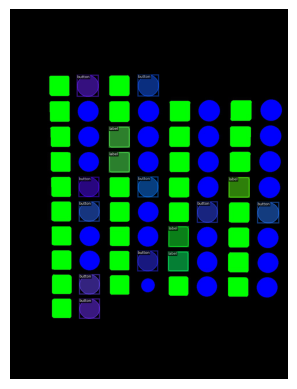

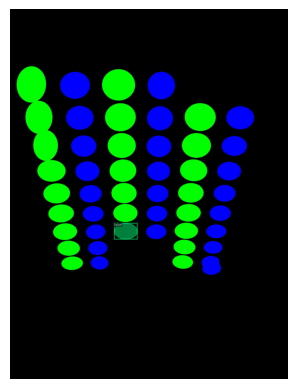

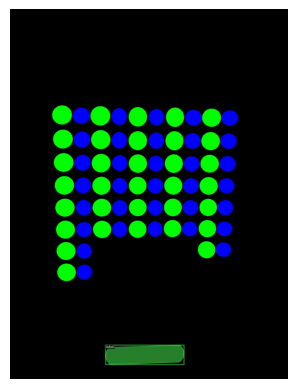

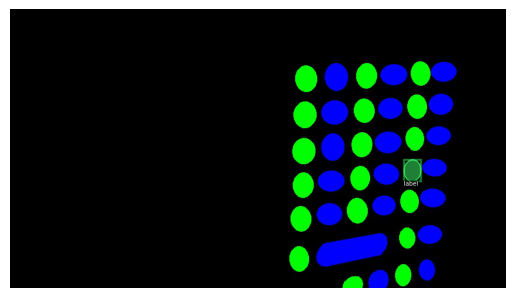

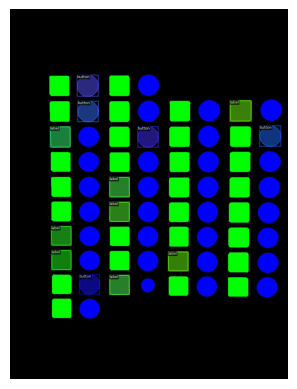

In [5]:
for d in random.sample(trainset, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(
        img[:, :, ::-1],
        metadata=MetadataCatalog.get("train"),
        scale=1,
        instance_mode=ColorMode.SEGMENTATION,
    )
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image())
    plt.axis("off")
    plt.show()

### Validation Loop using Validation Loss

In [6]:
def validation_loop(model: torch.nn, dataloader: torch.utils.data.DataLoader) -> dict:
    """
    Validate model on the given dataloader. Put model in training mode to output loss
    dict but do not backpropogate gradients. Largely adapted from train_loop.py and
    inference_on_dataset

    Args:
        model (torch.nn): model to validate
        dataloader (torch.utils.data.DataLoader): validation dataloader set to training
            mode

    Returns:
        dict: {"validation_loss": val_loss}
    """
    model.train()
    num_batches = len(dataloader)
    num_warmup = min(5, num_batches - 1)
    start_time = time.perf_counter()
    total_compute_time = 0
    losses = []
    for idx, data in enumerate(dataloader):
        if idx == num_warmup:
            start_time = time.perf_counter()
            total_compute_time = 0
        start_compute_time = time.perf_counter()
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        total_compute_time += time.perf_counter() - start_compute_time
        iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
        seconds_per_img = total_compute_time / iters_after_start
        if idx >= num_warmup * 2 or seconds_per_img > 5:
            total_seconds_per_img = (
                time.perf_counter() - start_time
            ) / iters_after_start
            eta = datetime.timedelta(
                seconds=int(total_seconds_per_img) * (num_batches - idx - 1)
            )
            log_every_n_seconds(
                logging.INFO,
                "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                    idx + 1, num_batches, seconds_per_img, str(eta)
                ),
                n=5,
            )

        batch_loss_dict = model(data)
        batch_loss_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in batch_loss_dict.items()
        }
        total_batch_loss = sum(loss for loss in batch_loss_dict.values())
        losses.append(total_batch_loss)
    val_loss = np.mean(losses)
    comm.synchronize()
    log_every_n_seconds(logging.INFO, f"VALIDATION_LOSS: {val_loss:.5f}")
    return {"validation_loss": val_loss}

### Define Custom Random Rotation Transformation

Defines a policy to randomly rotate images within a range

In [7]:
class RandomRotationWithProb(T.Augmentation):
    def __init__(self, prob: float) -> None:
        super().__init__()
        self.prob = prob

    def get_transform(self, image: np.ndarray) -> T.Transform:
        r = random.random()
        if r < self.prob:
            return T.RandomRotation(angle=[-15, 15]).get_transform(image=image)
        else:
            return T.NoOpTransform()

### Define a Custom Trainer

Add custom hooks and custom validation loader \
Modify validation loader so it loads gt_masks for validation loop

In [8]:
class Trainer(DefaultTrainer):
    @classmethod
    def build_validation_loader(cls, cfg):
        return build_detection_test_loader(
            dataset=get_detection_dataset_dicts(
                cfg.DATASETS.VAL[0], filter_empty=False
            ),
            mapper=DatasetMapper(cfg, is_train=True)
        )

    def build_hooks(self) -> list:
        """
        Overwrite the evaluation loop and checkpoint using best validation loss

        Returns:
            list: list of hooks
        """
        hooks = super().build_hooks()
        # remove existing EvalHook
        if comm.is_main_process():
            del hooks[-2]
            del hooks[-2]
        else:
            del hooks[-1]
        hooks.extend(
            [
                EvalHook(
                    eval_period=self.cfg.TEST.EVAL_PERIOD,
                    eval_function=lambda: validation_loop(
                        self.model,
                        self.build_validation_loader(self.cfg),
                    ),
                    eval_after_train=True,
                ),
                BestCheckpointer(
                    eval_period=self.cfg.TEST.EVAL_PERIOD,
                    checkpointer=self.checkpointer,
                    val_metric="validation_loss",
                    mode="min",
                ),
            ]
        )
        return hooks

### Define Config for Building Model

In [9]:
mask_rcnn_res50 = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
mask_rcnn_res101 = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
cascade_mask_rcnn_res50 = "Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml"

base_cfg = mask_rcnn_res101

cfg = get_cfg()
cfg.merge_from_file(
    model_zoo.get_config_file(base_cfg)
)

# start from pretrained weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(base_cfg)

# assign datasets and adjust ROI HEADS to match num classes
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.VAL = ("val",)
cfg.DATASETS.TEST = ("test",)
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False
cfg.INPUT.RANDOM_FLIP = "none"
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

# Calculate training logic
epochs = 30
batch_size = 2
eval_period = 1
iters_per_epoch = math.ceil(len(trainset) / batch_size)

cfg.SOLVER.IMS_PER_BATCH = batch_size
cfg.SOLVER.MAX_ITER = iters_per_epoch * epochs
cfg.TEST.EVAL_PERIOD = iters_per_epoch * eval_period
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.STEPS = [int(0.7 * cfg.SOLVER.MAX_ITER), int(0.8 * cfg.SOLVER.MAX_ITER)]
cfg.SOLVER.WARMUP_ITERS = int(0.067 * cfg.SOLVER.MAX_ITER)

# SAVE DIR
cfg.OUTPUT_DIR = "./output"

### Train Configured Model

Use modified DefaultTrainer

In [10]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/20 15:54:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[02/20 15:55:42 d2.engine.train_loop]: Starting training from iteration 0


/home/abhinavchadaga/miniforge3/envs/d2/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541702/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/20 15:55:47 d2.utils.events]:  eta: 2:31:59  iter: 19  total_loss: 2.475  loss_cls: 1.346  loss_box_reg: 0.000462  loss_mask: 0.694  loss_rpn_cls: 0.3739  loss_rpn_loc: 0.0327  time: 0.1814  last_time: 0.1763  data_time: 0.0153  last_data_time: 0.0017   lr: 1.6379e-06  max_mem: 3686M
[02/20 15:55:50 d2.utils.events]:  eta: 2:30:06  iter: 39  total_loss: 2.305  loss_cls: 1.236  loss_box_reg: 0.0004398  loss_mask: 0.6944  loss_rpn_cls: 0.3418  loss_rpn_loc: 0.02224  time: 0.1759  last_time: 0.1763  data_time: 0.0021  last_data_time: 0.0021   lr: 3.0989e-06  max_mem: 3686M
[02/20 15:55:53 d2.utils.events]:  eta: 2:27:48  iter: 59  total_loss: 2.296  loss_cls: 1.04  loss_box_reg: 0.005499  loss_mask: 0.6927  loss_rpn_cls: 0.4908  loss_rpn_loc: 0.03076  time: 0.1724  last_time: 0.1907  data_time: 0.0024  last_data_time: 0.0005   lr: 4.5598e-06  max_mem: 3686M
[02/20 15:55:57 d2.utils.events]:  eta: 2:28:14  iter: 79  total_loss: 1.817  loss_cls: 0.8251  loss_box_reg: 0.003908  loss_mask

### Plot Training and Validation Curves

In [10]:
def load_json_arr(json_path):
    train, val = [], []
    with open(json_path, 'r') as f:
        for line in f:
            l = json.loads(line)
            if "validation_loss" in l:
                val.append(l)
            elif "total_loss" in l:
                train.append(l)
    return train, val

In [11]:
train_metrics, val_metrics = load_json_arr(os.path.join(cfg.OUTPUT_DIR, "metrics.json"))
train_metrics = train_metrics[2:]

In [12]:
train_iters = [x["iteration"] for x in train_metrics]
train_loss = [x["total_loss"] for x in train_metrics]

val_iters = [x["iteration"] for x in val_metrics]
val_loss = [x["validation_loss"] for x in val_metrics]

min_val_loss_idx = np.argmin(val_loss)
print(f"min val loss of {val_loss[min_val_loss_idx]:.2f} at iteration {val_iters[min_val_loss_idx]}")

min val loss of 0.56 at iteration 8504


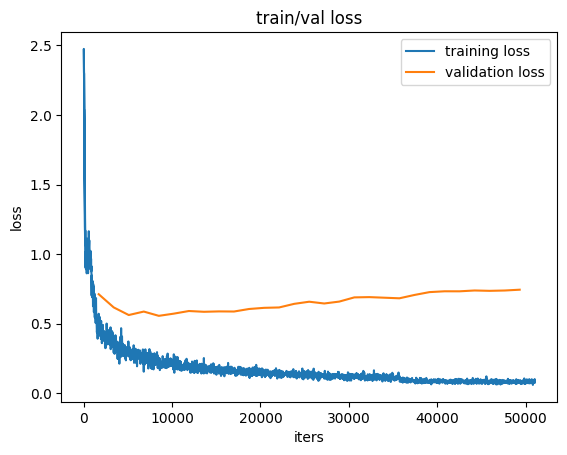

In [13]:
plt.plot(train_iters, train_loss)
plt.plot(val_iters, val_loss)
plt.xlabel("iters")
plt.ylabel("loss")
plt.title("train/val loss")
plt.legend(["training loss", "validation loss"], loc="upper right")
plt.show()

### Evalatuate Model on Held Out Testset

Using Default Predictor with Threshold of 0.7

In [14]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_best.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

[02/20 19:51:05 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_best.pth ...


In [15]:
evaluator = COCOEvaluator(dataset_name="test", output_dir=os.path.join(cfg.OUTPUT_DIR, "inference"), allow_cached_coco=False, use_fast_impl=False)
testloader = build_detection_test_loader(cfg, "test")
print(inference_on_dataset(predictor.model, testloader, evaluator))

[02/20 19:51:05 d2.evaluation.coco_evaluation]: Trying to convert 'test' to COCO format ...
[02/20 19:51:05 d2.data.datasets.coco]: Converting annotations of dataset 'test' to COCO format ...)
[02/20 19:51:24 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[02/20 19:51:25 d2.data.datasets.coco]: Conversion finished, #images: 1668, #annotations: 6113
[02/20 19:51:25 d2.data.datasets.coco]: Caching COCO format annotations at './output/inference/test_coco_format.json' ...
[02/20 19:51:44 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/20 19:51:44 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/20 19:51:44 d2.data.common]: Serializing 1668 elements to byte tensors and concatenating them all ...
[02/20 19:51:45 d2.data.common]: Serialized dataset takes 22.93 MiB
[02/20 19:51:45 d2.evaluation.evaluat

/home/abhinavchadaga/miniforge3/envs/d2/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541702/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/20 19:51:46 d2.evaluation.evaluator]: Inference done 11/1668. Dataloading: 0.0006 s/iter. Inference: 0.0338 s/iter. Eval: 0.0034 s/iter. Total: 0.0379 s/iter. ETA=0:01:02
[02/20 19:51:52 d2.evaluation.evaluator]: Inference done 128/1668. Dataloading: 0.0007 s/iter. Inference: 0.0336 s/iter. Eval: 0.0085 s/iter. Total: 0.0428 s/iter. ETA=0:01:05
[02/20 19:51:57 d2.evaluation.evaluator]: Inference done 251/1668. Dataloading: 0.0007 s/iter. Inference: 0.0350 s/iter. Eval: 0.0061 s/iter. Total: 0.0419 s/iter. ETA=0:00:59
[02/20 19:52:02 d2.evaluation.evaluator]: Inference done 380/1668. Dataloading: 0.0007 s/iter. Inference: 0.0359 s/iter. Eval: 0.0043 s/iter. Total: 0.0409 s/iter. ETA=0:00:52
[02/20 19:52:07 d2.evaluation.evaluator]: Inference done 484/1668. Dataloading: 0.0007 s/iter. Inference: 0.0361 s/iter. Eval: 0.0057 s/iter. Total: 0.0425 s/iter. ETA=0:00:50
[02/20 19:52:12 d2.evaluation.evaluator]: Inference done 607/1668. Dataloading: 0.0007 s/iter. Inference: 0.0363 s/iter. 

### View Output of Model on Test Images

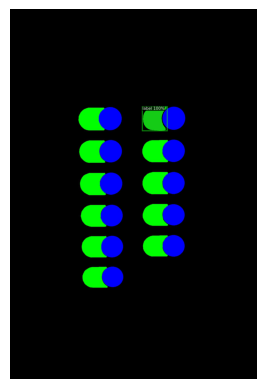

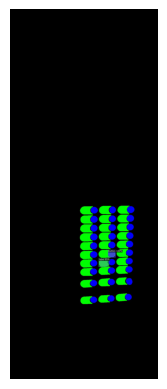

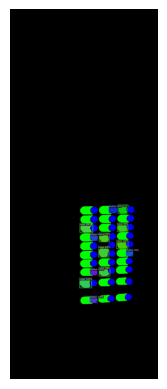

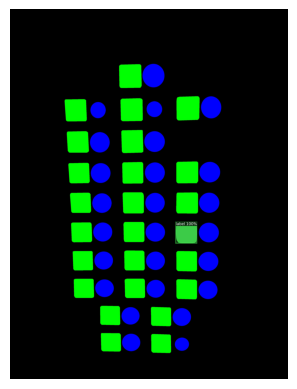

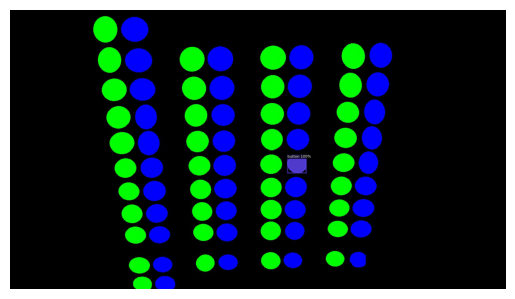

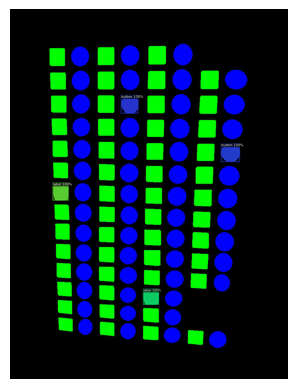

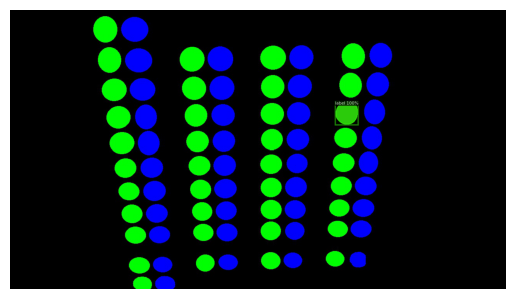

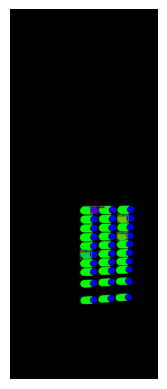

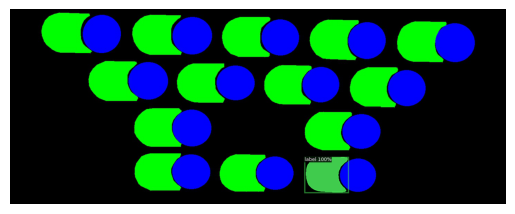

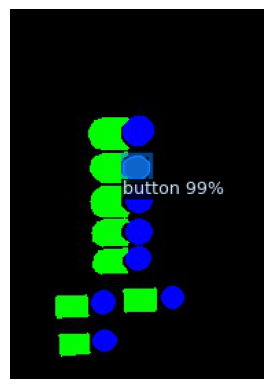

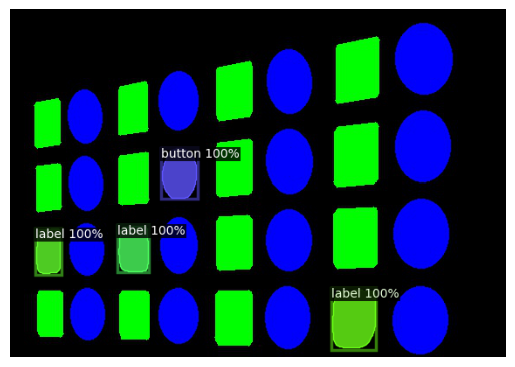

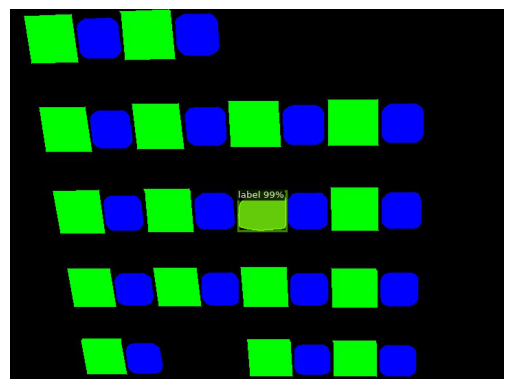

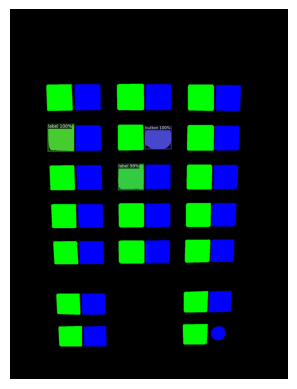

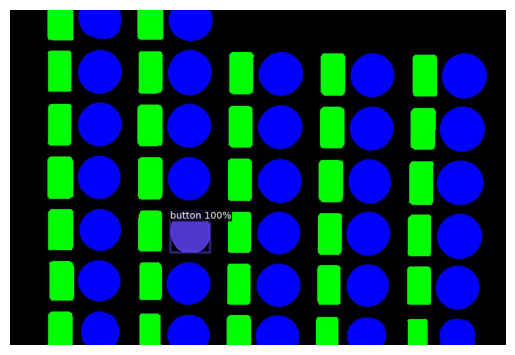

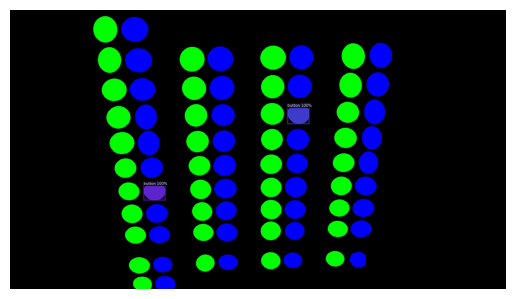

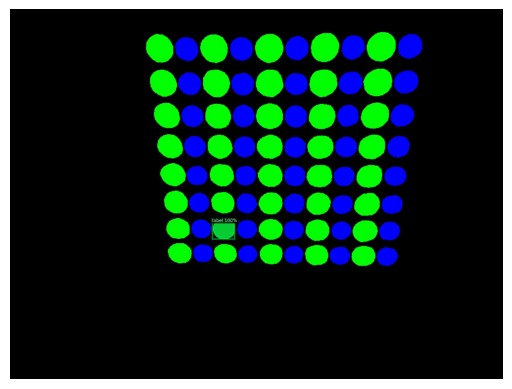

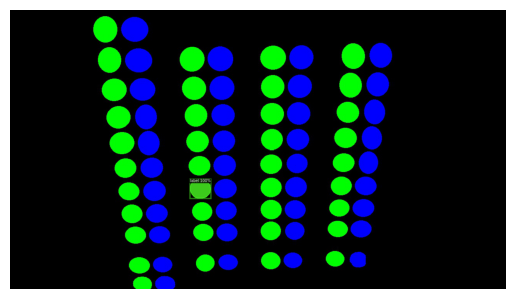

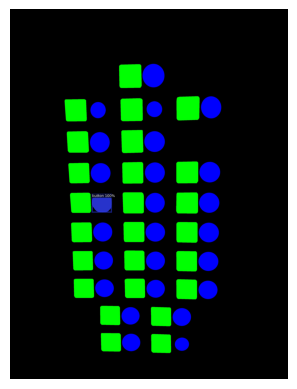

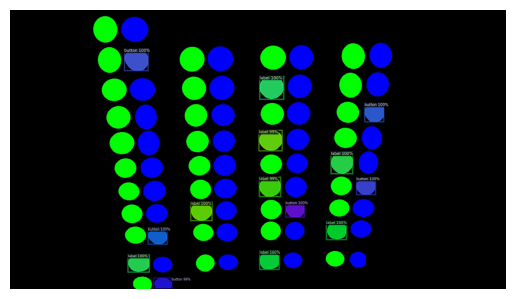

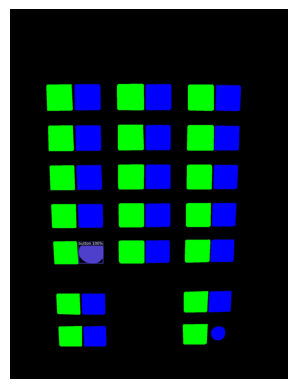

In [16]:
testset = get_detection_dataset_dicts("test", filter_empty=False)
save_dir = os.path.join(cfg.OUTPUT_DIR, "testImages")
os.makedirs(save_dir, exist_ok=True)
for i, d in enumerate(random.sample(testset, 20)):
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("test"), scale=1.0, instance_mode=ColorMode.SEGMENTATION)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imwrite(os.path.join(save_dir, f"{i}.jpg"), out.get_image()[:, :, ::-1])
    plt.imshow(out.get_image())
    plt.axis("off")
    plt.show()